In [1]:
import math, random, time
import gym
import numpy as np
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
sys.path.append('../')
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
from common.entropy import *

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

<h3> Set configuration </h3>

In [5]:
from common.config import *
cfg = Config()

<h1>Atari Environment</h1>

In [6]:
env_id = "DemonAttackNoFrameskip-v0"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

<h3>Use Cuda</h3>

In [7]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [8]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [9]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2> Deep Q Network </h2>

In [11]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x /= 255.0
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state):
        state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        action  = q_value.max(1)[1].data[0]
        return action
    
    def predict(self, state):
        state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        return q_value
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 and classname.find('Layer') == -1:
            nn.init.xavier_normal(m.weight)
        elif classname.find('Linear') != -1:
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0.1)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal(1.0, 0.02)
            m.bias.data.fill(0)

In [19]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model = CnnDQN(env.observation_space.shape, env.action_space.n)

#if cfg.INITIALIZER == 'Xavier':
#    current_model.apply(current_model.weights_init)
#    nn.init.normal(current_model.fc[2].weight.data,0,0.01)
#    nn.init.constant(current_model.fc[2].bias.data,0)
#    print('Initialized with Xavier initializer')

if USE_CUDA:
    current_model = current_model.cuda()
    target_model = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=1e-4)

replay_initial = cfg.REPLAY_INIT
replay_buffer = ReplayBuffer(cfg.REPLAY_BUFFER)

### Synchronize current net and target net

In [20]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [21]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

## Q Entropy Threshold

In [22]:
entropy_threshold = np.log(env.action_space.n) * 0.95#cfg.Q_ENTROPY_THRESHOLD
qe_max = np.log(env.action_space.n)
print('entropy maximum: %.3f, threshold: %.3f' %(qe_max, entropy_threshold))

entropy maximum: 1.792, threshold: 1.702


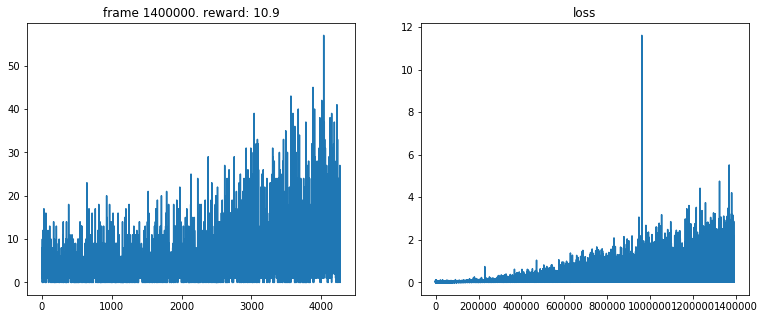

In [23]:
num_frames = cfg.NUM_FRAMES
batch_size = cfg.BATCH_SIZE
gamma      = cfg.GAMMA
episode = 0

losses = []
all_rewards = []
episode_reward = 0

state_traj = []
q_value_traj = []

episode_state = []
episode_q_val = []

"""
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
"""

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    q_values = current_model.predict(state).data.cpu().numpy()[0]
    q_values -= np.max(q_values)
    q_values += np.log(np.finfo(np.float64).max/q_values.shape[-1])*0.9
    q_values = q_values.astype(np.float64)
    q_entropy = entropy(q_values)
    
    if frame_idx % 100 == 0:
        q_value_str = ''
        for q_val in q_values:
            q_value_str += str(round(q_val, 2)) + "  "
        """
        ax.clear()
        plt.ylim(0,800)
        ax.bar(range(env.action_space.n), QQ)
        fig.canvas.draw()
        """
        print('\rframe: %5d (%.2f%%), q_entropy: %.3f, (%.2f%% of max),\t\t\t\t\t\t\t\t\t\t q_value: '
        %(frame_idx, (frame_idx/num_frames*100), q_entropy, (q_entropy/qe_max)*100), q_value_str, end='')

    if q_entropy > entropy_threshold:
        action = env.action_space.sample()
    else:
        action = current_model.act(state=state)
    
    
    if episode % 20 == 0:
        episode_state.append(state)
        episode_q_val.append(q_values)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        if episode % 20 == 0:
            state_traj.append(episode_state)
            q_value_traj.append(episode_q_val)
        
        episode += 1
        episode_state = []
        episode_q_val = []
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        update_target(current_model, target_model)
        
    #print('frame_idx: ', frame_idx, end='')

In [ ]:
from common.save_file import *

model_dir = "model"
var_dir = "var"
name = "qEntropy_" + env_id

save_model(current_model, model_dir, name)

var_dict = {
            "all_rewards": all_rewards,
            "losses": losses,
            "state_traj": state_traj,
            "q_value_traj": q_value_traj,
           }

save_variable(name, var_dir, var_dict)
